# Install environment
### you'll need [anaconda](https://www.anaconda.com/download)
### see [ultralytics](https://docs.ultralytics.com/quickstart/)
```bash
conda create -n kibo python=3.11
conda activate kibo
# Install the ultralytics package from PyPI
pip install ultralytics
pip install matplotlib
```
### You'll need to install [pytorch](https://pytorch.org/get-started/locally/)
### for windows with nvdia gpu
```bash
conda install cudatooolkit=11.8
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
```
### other os or gpu... god bless you

### TODO: env in google colab

# Check installation of pytorch

In [4]:
import torch
import os

print(torch.__version__)
if os.name == 'nt':
    # windows
    print(f'cuda: {torch.cuda.is_available()}')
else:
    # mac
    print(f'mps: {torch.backends.mps.is_available()}')


2.2.2+cu118
cuda: True


# Prepare [dataset](https://docs.ultralytics.com/zh/datasets/) by randomly generate items
### sturcture of dataset
```batch
datasets/
├── train/
│   ├── images/
│   └── labels/
└── val/
    ├── images/
    └── labels/
```

### create dataset sturcture

In [5]:
import os

print(f'current dir: {os.getcwd()}')

# create dataset sturcture
base_dir = os.getcwd()
dataset = os.path.join(base_dir, 'datasets')
os.makedirs(dataset, exist_ok=True)
os.makedirs(os.path.join(dataset, "train"), exist_ok=True)
os.makedirs(os.path.join(dataset, "val"), exist_ok=True)
os.makedirs(os.path.join(dataset, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(dataset, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(dataset, "val", "images"), exist_ok=True)
os.makedirs(os.path.join(dataset, "val", "labels"), exist_ok=True)

# print dataset structure
for root, dirs, files in os.walk(dataset):
    level = root.replace(dataset, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)


current dir: d:\Programming\JAVA\Kibo\kibo5th\test
datasets/
    train/
        images/
        labels/
    val/
        images/
        labels/


# create dataset
### config

train count: 789, val count: 198


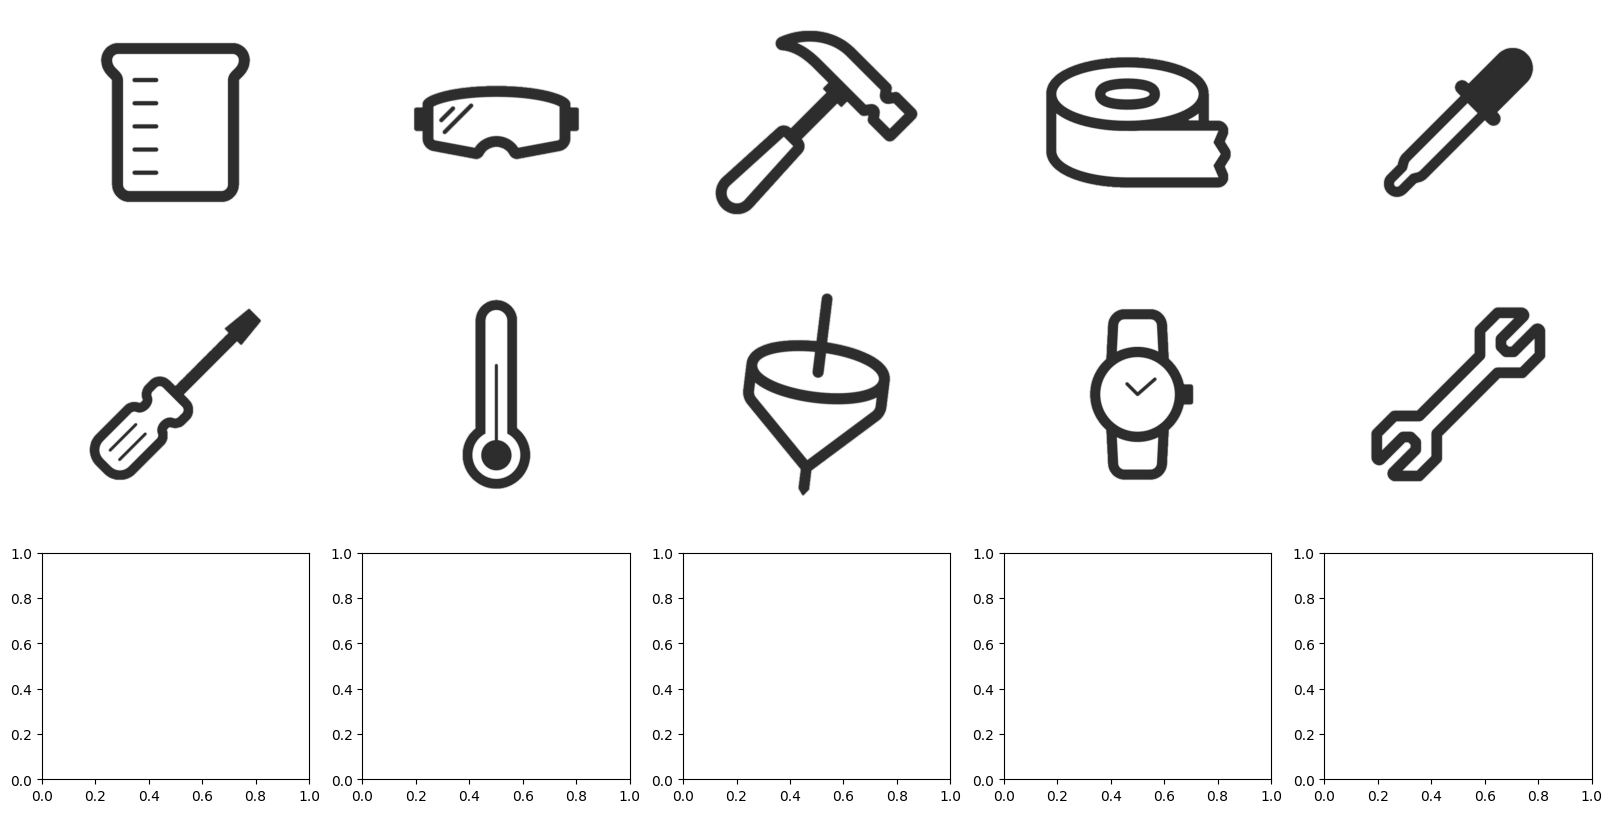

In [6]:
train_val_ratio = 0.8
data_count = 987

train_count = int(data_count * train_val_ratio)
val_count = int(data_count - train_count)
print(f"train count: {train_count}, val count: {val_count}")

width, height = 640, 640

# show images
from PIL import Image
import matplotlib.pyplot as plt

item_image_dir = "lost_item_images"
images = os.listdir(item_image_dir)
# backgrounds_dir = "backgrounds"
# backgrounds = os.listdir(backgrounds_dir)


plt.subplots(3, 5, figsize=(20, 10))
for i, image in enumerate(images[:10]):
    img = Image.open(os.path.join(item_image_dir, image))
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
# for i, background in enumerate(backgrounds[:10]):
#     img = Image.open(os.path.join(backgrounds_dir, background))
#     plt.subplot(3, 5, i+11)
#     plt.imshow(img)
#     plt.axis('off')

In [7]:
# Assuming `images` is defined somewhere before this code snippet
item_names = sorted([name.split(".")[0] for name in images])
print(f"item names: {item_names}")

item_dict = {name: i for i, name in enumerate(item_names)}
for i, name in enumerate(item_names):
    print(f"\t{i}: {name}")

item names: ['beaker', 'goggle', 'hammer', 'kapton_tape', 'pipette', 'screwdriver', 'thermometer', 'top', 'watch', 'wrench']
	0: beaker
	1: goggle
	2: hammer
	3: kapton_tape
	4: pipette
	5: screwdriver
	6: thermometer
	7: top
	8: watch
	9: wrench


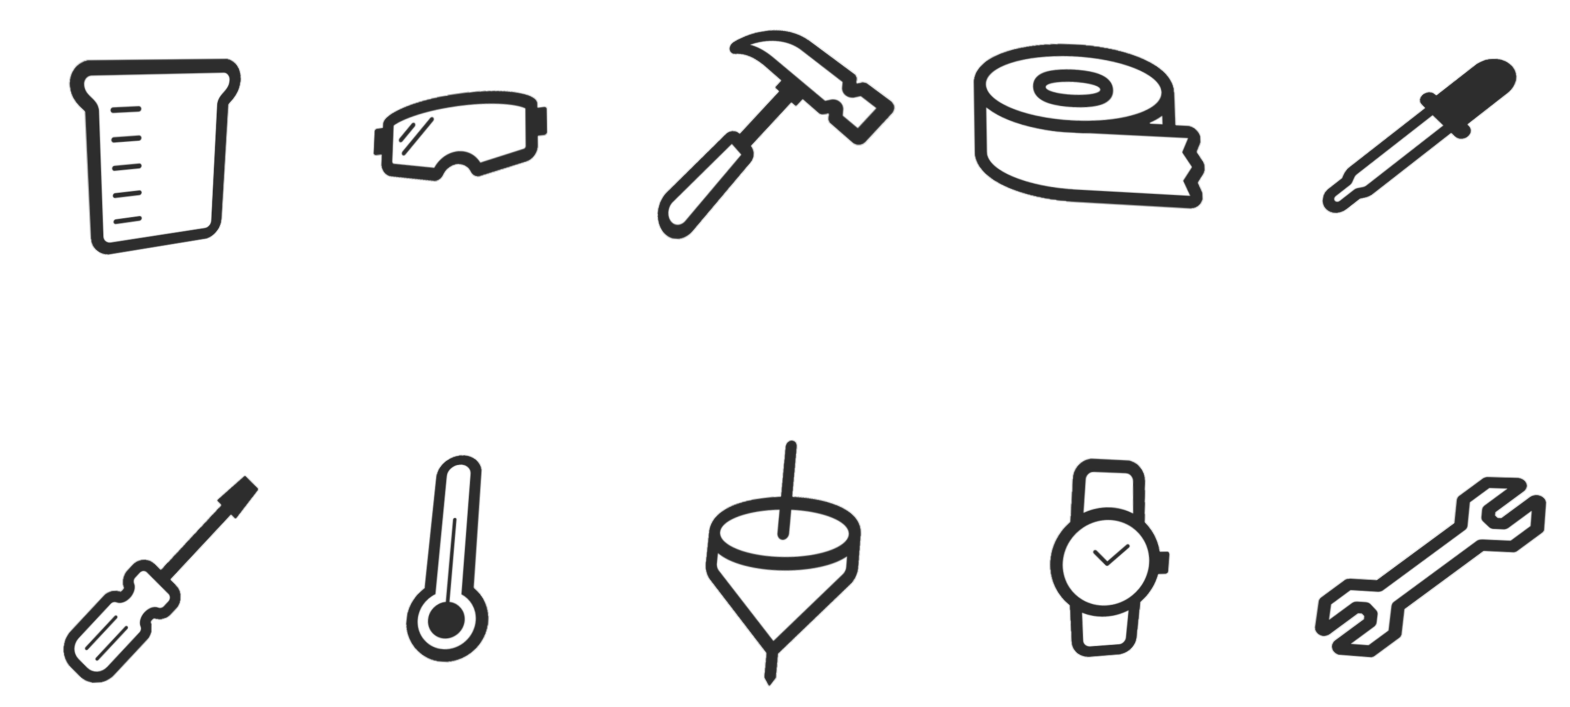

In [8]:
import cv2
import numpy as np
import random


def get_perspective_mat(width, height, temp=0.1):
    src_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)
    dst_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)
    for i in range(4):
        dst_pts[i] += random.uniform(-temp, temp) * width
    perspective_mat = cv2.getPerspectiveTransform(src_pts, dst_pts)
    return perspective_mat

def adjust_perpective(image, width, height):
    image = np.array(image)
    image = cv2.warpPerspective(
        image, get_perspective_mat(width, height), (width, height)
    )
    return image


item_width, item_height = 478, 478

# show transformed images
plt.subplots(2, 5, figsize=(20, 10))
for i, image in enumerate(images[:10]):
    img = Image.open(os.path.join(item_image_dir, image))
    img = adjust_perpective(img, item_width, item_height)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

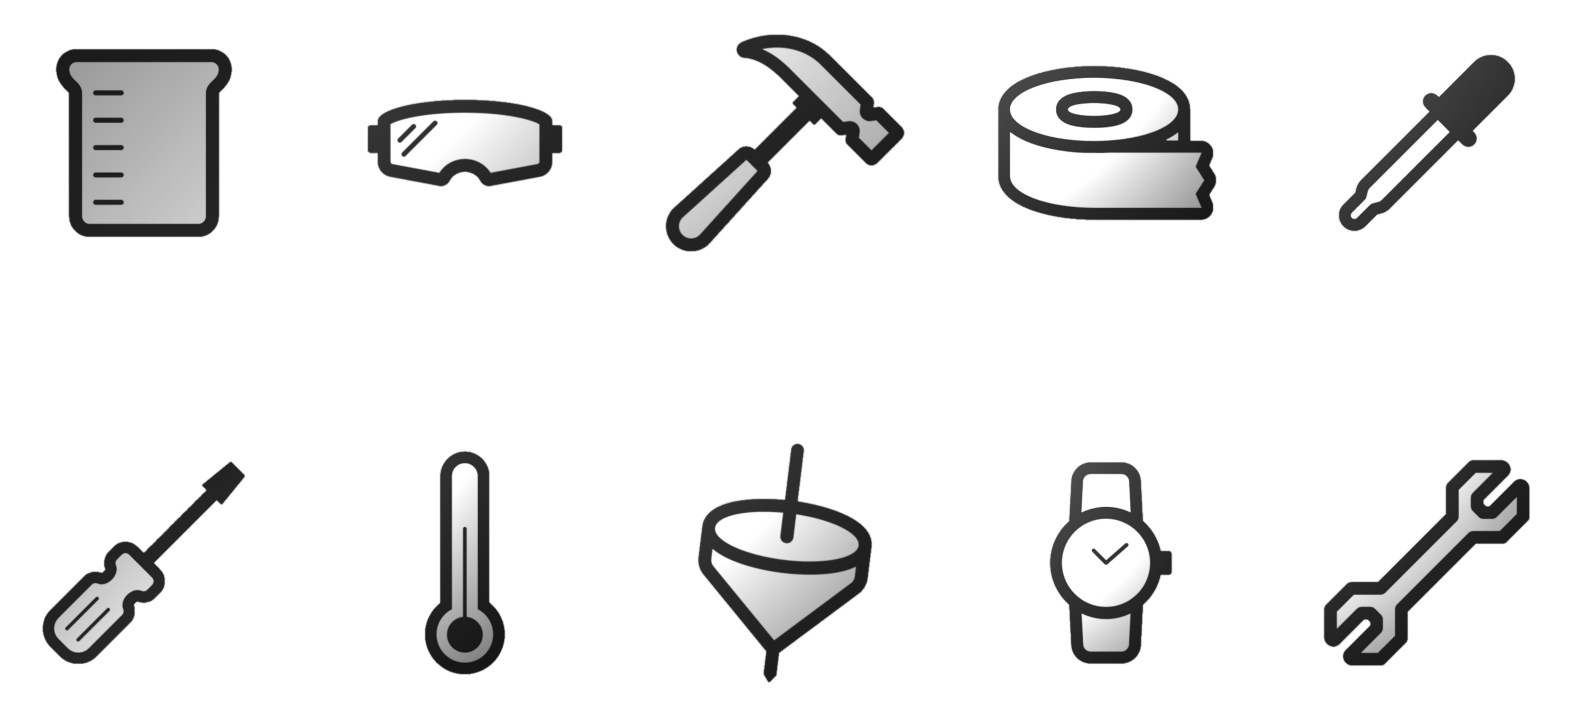

In [9]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt


def adjust_brightness(image, temp=0.2):
    image = image.astype(np.float32)
    horizontal_gradient = np.linspace(1 - temp, 1 + temp, image.shape[1]) * np.random.uniform(0.8, 1.2)
    mask = np.ones_like(image, dtype=np.float32)
    mask[:, :, 0] = horizontal_gradient
    mask[:, :, 1] = horizontal_gradient
    mask[:, :, 2] = horizontal_gradient
    cv2.multiply(image, mask, image)
    vertical_gradient = np.linspace(1 - temp, 1 + temp, image.shape[0]) * np.random.uniform(0.8, 1.2)
    mask = np.ones_like(image, dtype=np.float32)
    mask[:, :, 0] = vertical_gradient[:, np.newaxis]
    mask[:, :, 1] = vertical_gradient[:, np.newaxis]
    mask[:, :, 2] = vertical_gradient[:, np.newaxis]
    cv2.multiply(image, mask, image)
    image = np.clip(image, 0, 255).astype(np.uint8)
    return image


# show transformed images
plt.subplots(2, 5, figsize=(20, 10))
for i, image in enumerate(images[:10]):
    img = cv2.imread(os.path.join(item_image_dir, image), cv2.IMREAD_UNCHANGED)
    img = adjust_brightness(img, np.random.uniform(-0.5, 0.5))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

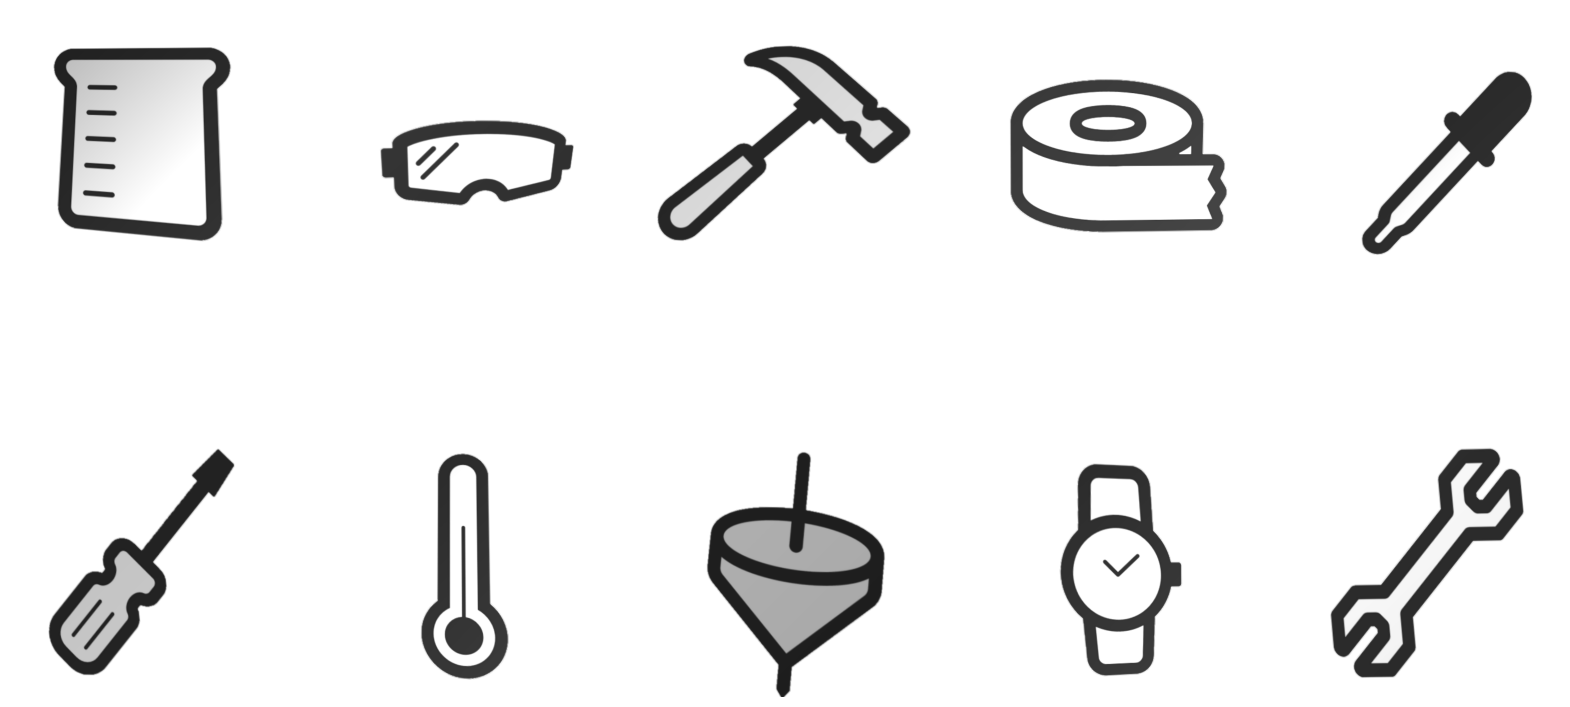

In [10]:
# tilted and dimmed images
plt.subplots(2, 5, figsize=(20, 10))
for i, image in enumerate(images[:10]):
    img = Image.open(os.path.join(item_image_dir, image))
    img = adjust_perpective(img, item_width, item_height)
    img = adjust_brightness(np.array(img), np.random.uniform(-0.2, 0.2))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

### generate

In [11]:
import random
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output


def get_yolo_bbox(x1, y1, x2, y2, width, height):
    x_center = (x1 + x2) / (2 * width)
    y_center = (y1 + y2) / (2 * height)
    bbox_width = (x2 - x1) / width
    bbox_height = (y2 - y1) / height
    return x_center, y_center, bbox_width, bbox_height


def put_image(width, height, plane, item_image, x, y, angle, scale):
    item_height, item_width, channels = item_image.shape

    # Rotation matrix
    M = cv2.getRotationMatrix2D((item_width / 2, item_height / 2), angle, scale)
    rotated_corners = np.array(
        [[[0, 0], [item_width, 0], [item_width, item_height], [0, item_height]]],
        dtype=np.float32,
    )
    rotated_corners = cv2.transform(rotated_corners, M)[0]

    # Rotate image
    item_image_rotated = cv2.warpAffine(
        item_image, M, (item_width, item_height), borderValue=(255, 255, 255, 0)
    )

    x_min = int(min(rotated_corners[:, 0]))
    x_max = int(max(rotated_corners[:, 0]))
    y_min = int(min(rotated_corners[:, 1]))
    y_max = int(max(rotated_corners[:, 1]))

    # Cut the image
    item_image_rotated = item_image_rotated[y_min:y_max, x_min:x_max]

    x1 = x
    y1 = y
    x2 = x + item_image_rotated.shape[1]
    y2 = y + item_image_rotated.shape[0]

    if x1 < 0 or y1 < 0 or x2 > width or y2 > height:
        return False, None

    bbox = get_yolo_bbox(x1, y1, x2, y2, width, height)
    plane_slice = plane[y1:y2, x1:x2]

    # Alpha blending
    item_image_rotated_alpha = item_image_rotated[:, :, 3] / 255.0
    for c in range(3):
        plane_slice[:, :, c] = (
            item_image_rotated_alpha * item_image_rotated[:, :, c]
            + (1.0 - item_image_rotated_alpha) * plane_slice[:, :, c]
        )

    return True, bbox


def generate_image(item_image, background, item_count, height, width):
    # if random.random() < 0.5:
    plane = np.zeros((height, width, 4), dtype=np.uint8)    # 640 * 640 black background
    # put a 640 * 480 white background in the center
    sub_plane = np.ones((480, 640, 4), dtype=np.uint8) * 255
    sub_plane = adjust_brightness(sub_plane, np.random.uniform(-0.2, 0.2))
    plane[80:560, :, :] = sub_plane
    # else:
    #     plane = cv2.imread(os.path.join(backgrounds_dir, background))
    #     plane = cv2.resize(plane, (width, height))

    count = 0
    bboxs = []
    while count < item_count:
        scale = random.uniform(0.1, 0.7)
        x, y = random.randint(0, width), random.randint(0, height)
        angle = random.randint(0, 360)
        if random.random() < 0.25:
            item_image = adjust_brightness(item_image, np.random.uniform(-0.2, 0.2))
        if random.random() < 0.25:
            item_image = adjust_perpective(item_image, item_width, item_height)
        success, bbox = put_image(width, height, plane, item_image, x, y, angle, scale)
        if success:
            count += 1
            bboxs.append(bbox)

    return plane, bboxs


def generate_images(
    item_images, backgrounds, item_dict, save_dir, height, width, count
):
    for i in range(count):
        choice = random.choice(item_images)
        item_image = cv2.imread(
            os.path.join(item_image_dir, choice), cv2.IMREAD_UNCHANGED
        )
        item_count = random.randint(1, 5)
        background = random.choice(backgrounds)
        plane, bboxs = generate_image(item_image, background, item_count, height, width)
        image_path = os.path.join(save_dir, "images", f"{i}.png")
        label_path = os.path.join(save_dir, "labels", f"{i}.txt")
        cv2.imwrite(image_path, plane)
        with open(label_path, "w") as f:
            for bbox in bboxs:
                class_id = item_dict[choice.split(".")[0]]
                f.write(f"{class_id} ")
                f.write(" ".join(map(str, bbox)) + "\n")


In [12]:
backgrounds = "dummy"
generate_images(
    images,
    backgrounds,
    item_dict,
    os.path.join(dataset, "train"),
    height,
    width,
    train_count,
)
generate_images(
    images,
    backgrounds,
    item_dict,
    os.path.join(dataset, "val"),
    height,
    width,
    val_count,
)

# pending data (directly add lost items to dataset)

In [13]:
from PIL import Image


pending_data_count = int(data_count * 0.2)


# with no background

for i in range(pending_data_count):
    choice = random.choice(images)
    item_image = cv2.imread(os.path.join(item_image_dir, choice), cv2.IMREAD_UNCHANGED)
    item_image = adjust_brightness(item_image, np.random.uniform(-0.2, 0.2))
    item_image = adjust_perpective(item_image, item_width, item_height)
    bbox = get_yolo_bbox(0, 0, item_width, item_height, item_width, item_height)
    image_path = os.path.join(dataset, "train", "images", f"{i+train_count}.png")
    label_path = os.path.join(dataset, "train", "labels", f"{i+train_count}.txt")
    cv2.imwrite(image_path, item_image)
    with open(label_path, "w") as f:
        class_id = item_dict[choice.split(".")[0]]
        f.write(f"{class_id} ")
        f.write(" ".join(map(str, bbox)) + "\n")

# with white background
image_dir_ = "lost_item_images_w"
images_w = os.listdir(image_dir_)

for i in range(pending_data_count, 2 * pending_data_count):
    choice = random.choice(images_w)
    item_image = Image.open(os.path.join(image_dir_, choice))
    item_image = np.array(item_image.rotate(random.randint(0, 360)))
    item_image = adjust_brightness(item_image, np.random.uniform(-0.2, 0.2))
    item_image = adjust_perpective(item_image, item_width, item_height)
    bbox = get_yolo_bbox(0, 0, item_width, item_height, item_width, item_height)
    image_path = os.path.join(dataset, "train", "images", f"{i+train_count}.png")
    label_path = os.path.join(dataset, "train", "labels", f"{i+train_count}.txt")
    cv2.imwrite(image_path, item_image)
    with open(label_path, "w") as f:
        class_id = item_dict[choice.split(".")[0]]
        f.write(f"{class_id} ")
        f.write(" ".join(map(str, bbox)) + "\n")

# view bboxs

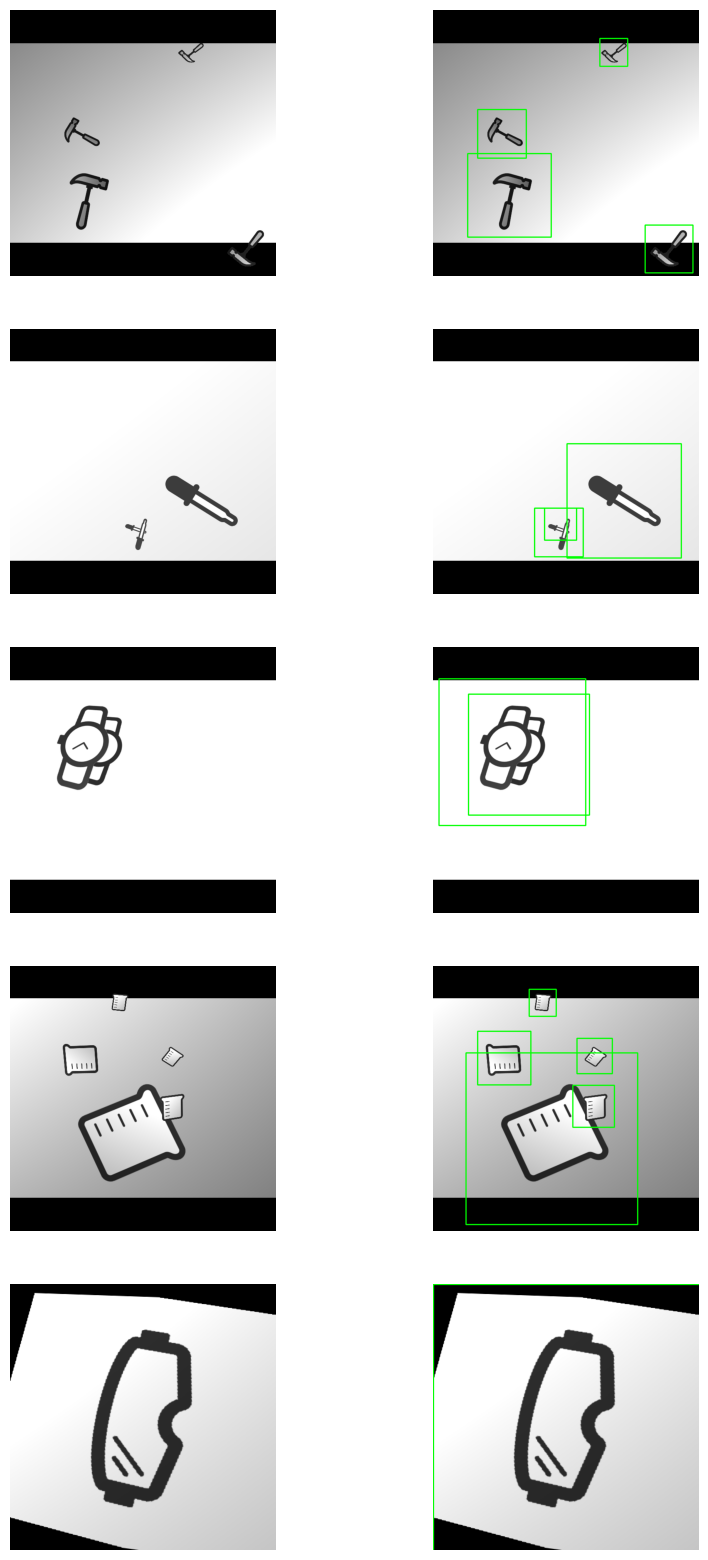

In [14]:
import os
import cv2
import matplotlib.pyplot as plt


def draw_bbox(image, bboxs, width, height):
    for bbox in bboxs:
        x_center, y_center, bbox_width, bbox_height = bbox
        x1 = int((x_center - bbox_width / 2) * width)
        y1 = int((y_center - bbox_height / 2) * height)
        x2 = int((x_center + bbox_width / 2) * width)
        y2 = int((y_center + bbox_height / 2) * height)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image

data_dir = "datasets/train"
images_ = sorted(os.listdir(os.path.join(data_dir, "images")))
labels_ = sorted(os.listdir(os.path.join(data_dir, "labels")))
plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    image = cv2.imread(os.path.join(data_dir, "images", images_[i]))
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    with open(os.path.join(data_dir, "labels", labels_[i])) as f:
        bboxs = [list(map(float, line.strip().split()[1:])) for line in f]
    image_with_bbox = draw_bbox(image, bboxs, width, height)
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.axis("off")

# raise Exception("stop here")

In [15]:
from ultralytics import YOLO
import os

model = YOLO("best.pt")
results =  model.train(data='kibo.yaml',  project=os.getcwd(), epochs=31, batch=-1)


Ultralytics YOLOv8.1.47  Python-3.11.8 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=best.pt, data=kibo.yaml, epochs=31, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=d:\Programming\JAVA\Kibo\kibo5th\test, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

train: Scanning D:\Programming\JAVA\Kibo\kibo5th\test\datasets\train\labels... 1183 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1183/1183 [00:01<00:00, 1182.70it/s]


train: New cache created: D:\Programming\JAVA\Kibo\kibo5th\test\datasets\train\labels.cache


val: Scanning D:\Programming\JAVA\Kibo\kibo5th\test\datasets\val\labels... 198 images, 0 backgrounds, 0 corrupt: 100%|██████████| 198/198 [00:00<00:00, 337.66it/s]


val: New cache created: D:\Programming\JAVA\Kibo\kibo5th\test\datasets\val\labels.cache
Plotting labels to d:\Programming\JAVA\Kibo\kibo5th\test\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000421875), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to d:\Programming\JAVA\Kibo\kibo5th\test\train3
Starting training for 31 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/31       3.6G      1.346      1.146      1.682         86        640: 100%|██████████| 44/44 [00:11<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

                   all        198        590      0.994      0.964       0.98      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/31      3.62G      1.252      1.036      1.656         88        640: 100%|██████████| 44/44 [00:09<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        198        590      0.985      0.963      0.982      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/31      3.62G      1.262       1.02      1.656         94        640: 100%|██████████| 44/44 [00:09<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        198        590      0.979      0.955      0.983      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/31       3.6G      1.255      1.037      1.637         94        640: 100%|██████████| 44/44 [00:09<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        198        590      0.981       0.96      0.982        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/31      3.61G      1.209      1.003      1.599         95        640: 100%|██████████| 44/44 [00:09<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all        198        590       0.98      0.952      0.981      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/31      3.61G      1.209     0.9699       1.61         91        640: 100%|██████████| 44/44 [00:09<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        198        590      0.979      0.937      0.979      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/31      3.61G       1.18     0.9368      1.583        112        640: 100%|██████████| 44/44 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        198        590       0.98      0.958      0.982      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/31      3.62G      1.168     0.9249      1.566         94        640: 100%|██████████| 44/44 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        198        590      0.986      0.969      0.988      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/31      3.61G      1.148     0.8925      1.546        104        640: 100%|██████████| 44/44 [00:09<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        198        590      0.981      0.967      0.988      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/31      3.61G      1.098     0.8872      1.509         97        640: 100%|██████████| 44/44 [00:09<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

                   all        198        590      0.991      0.957      0.985      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/31      3.62G      1.112     0.8638      1.508         92        640: 100%|██████████| 44/44 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

                   all        198        590      0.983      0.963      0.984      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/31      3.63G      1.091     0.8682      1.504        116        640: 100%|██████████| 44/44 [00:09<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        198        590      0.992      0.956      0.988      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/31      3.63G      1.083      0.874      1.501         99        640: 100%|██████████| 44/44 [00:09<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        198        590      0.983      0.967       0.99      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/31      3.61G      1.074     0.8411      1.466        117        640: 100%|██████████| 44/44 [00:09<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        198        590      0.981       0.97      0.985      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/31      3.62G      1.065     0.8256      1.485        103        640: 100%|██████████| 44/44 [00:09<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        198        590      0.991      0.965      0.985      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/31      3.61G      1.046     0.8163      1.449         97        640: 100%|██████████| 44/44 [00:09<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all        198        590      0.995      0.964      0.983      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/31      3.62G      1.017     0.8026      1.426         85        640: 100%|██████████| 44/44 [00:09<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        198        590      0.981       0.97      0.986      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/31      3.61G      1.006     0.8014      1.425        106        640: 100%|██████████| 44/44 [00:09<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        198        590      0.988      0.966      0.989      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/31      3.62G       1.02     0.7958      1.419        115        640: 100%|██████████| 44/44 [00:09<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        198        590      0.993      0.954      0.986       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/31      3.62G     0.9882     0.7648      1.405        114        640: 100%|██████████| 44/44 [00:09<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

                   all        198        590      0.991      0.978       0.99      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/31      3.61G     0.9948     0.7858      1.422         91        640: 100%|██████████| 44/44 [00:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        198        590      0.987      0.969      0.989      0.729


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/31      3.59G      1.027     0.4961      1.343         57        640: 100%|██████████| 44/44 [00:09<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

                   all        198        590      0.982      0.968      0.989      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/31      3.59G      1.003       0.46      1.284         50        640: 100%|██████████| 44/44 [00:09<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        198        590      0.979      0.981      0.992      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/31      3.59G     0.9948     0.4437      1.278         36        640: 100%|██████████| 44/44 [00:09<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        198        590      0.989      0.966      0.988      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/31      3.59G     0.9857     0.4365      1.258         62        640: 100%|██████████| 44/44 [00:09<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        198        590      0.981      0.978      0.987       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/31      3.59G     0.9783      0.429       1.25         45        640: 100%|██████████| 44/44 [00:09<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        198        590       0.99      0.967      0.987      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/31      3.59G     0.9653     0.4279       1.27         51        640: 100%|██████████| 44/44 [00:09<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        198        590      0.981      0.977      0.988      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/31      3.59G     0.9508     0.4195      1.248         52        640: 100%|██████████| 44/44 [00:09<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        198        590      0.989      0.967      0.987      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/31      3.59G     0.9322     0.4122      1.242         45        640: 100%|██████████| 44/44 [00:09<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        198        590      0.994      0.963      0.988       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/31      3.59G     0.9349     0.4028      1.224         39        640: 100%|██████████| 44/44 [00:09<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        198        590      0.984      0.976      0.988      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/31      3.59G     0.9195     0.4018      1.212         48        640: 100%|██████████| 44/44 [00:09<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

                   all        198        590      0.987      0.977      0.987      0.755



31 epochs completed in 0.105 hours.
Optimizer stripped from d:\Programming\JAVA\Kibo\kibo5th\test\train3\weights\last.pt, 6.3MB
Optimizer stripped from d:\Programming\JAVA\Kibo\kibo5th\test\train3\weights\best.pt, 6.3MB

Validating d:\Programming\JAVA\Kibo\kibo5th\test\train3\weights\best.pt...
Ultralytics YOLOv8.1.47  Python-3.11.8 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


                   all        198        590      0.987      0.977      0.987      0.756
                beaker        198         44      0.969          1      0.995      0.726
                goggle        198         68      0.971      0.999      0.994      0.738
                hammer        198         49          1      0.998      0.995      0.803
           kapton_tape        198         56      0.996      0.946       0.98      0.762
               pipette        198         67      0.987          1      0.995      0.806
           screwdriver        198         78      0.986      0.962      0.993      0.758
           thermometer        198         32          1      0.956      0.972       0.69
                   top        198         79      0.995          1      0.995      0.729
                 watch        198         63      0.984      0.993      0.995      0.793
                wrench        198         54       0.98       0.92      0.958      0.751
Speed: 0.4ms preproce

In [16]:
raise Exception("stop here")

Exception: stop here

In [17]:
from ultralytics import YOLO

model = YOLO("train9/weights/best.pt")
print(model.info())

Model summary: 225 layers, 3012798 parameters, 0 gradients, 8.2 GFLOPs
(225, 3012798, 0, 8.2038272)


In [19]:
from ultralytics import YOLO
import os
import cv2


model = YOLO("train3/weights/best.pt", task="detect")

test_dir = "test"


images_ = sorted((os.listdir(os.path.join(test_dir, "data"))))


images_names = [os.path.join(test_dir, "data", name) for name in images_]


save_dir = os.path.join(os.getcwd(), test_dir, "results")


save_names = [os.path.join(save_dir, f"{name}") for name in images_]
print(save_names)

# check all images' shape
for name, file in zip(save_names, images_names):
    results = model(file)

    for result in results:


        boxes = result.boxes  # Boxes object for bounding box outputs


        masks = result.masks  # Masks object for segmentation masks outputs


        keypoints = result.keypoints  # Keypoints object for pose outputs


        probs = result.probs  # Probs object for classification outputs


        result.save(filename=name)  # Save the image with bounding boxes

# results = model("test/data/45fb2e43-0564-41c0-8fb9-51f92c226a2e.png")

['d:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\45fb2e43-0564-41c0-8fb9-51f92c226a2e.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\63651b40-583c-4a42-a474-8bbc51e523f1.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\902d1d66-65d9-4069-a2ec-bf8443a07fd0.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\ac6f6197-1a3a-43f2-827d-0d1000dcc292.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\beaker.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\goggle.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\hammer.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\kapton_tape.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\pipette.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\screwdriver.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\thermometer.png', 'd:\\Programming\\JAVA\\Kibo\\kibo5th\\test\\test\\results\\

In [20]:
from ultralytics import YOLO

model = YOLO("train3\\weights\\best.pt")

success = model.export(format="onnx", opset=16)

Ultralytics YOLOv8.1.47  Python-3.11.8 torch-2.2.2+cu118 CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'train3\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (6.0 MB)

ONNX: starting export with onnx 1.16.0 opset 16...
ONNX: export success  0.9s, saved as 'train3\weights\best.onnx' (11.7 MB)

Export complete (3.0s)
Results saved to D:\Programming\JAVA\Kibo\kibo5th\test\train3\weights
Predict:         yolo predict task=detect model=train3\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=train3\weights\best.onnx imgsz=640 data=kibo.yaml  
Visualize:       https://netron.app
